<a href="https://colab.research.google.com/github/IanVlasov/NVidia_DL_in_CV/blob/lesson_7/Vlasov_Ian_HW07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Обработка видео
Классификация действий по видео

Много дополнительного накрутить не успел, добавил пайплайн данных и разделение на тестовую и тренировочную выборку + попробовал пулинг по временному измерению, так как без него по каким-то причинам у меня лосс со временем увеличивался (когда просто запускал ноутбук с урока)

## Переключение версии TensorFlow

In [0]:
%tensorflow_version 2.x

In [0]:
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import os
WORKING_DIR = '/content/gdrive/My Drive/DL_in_CV/Lesson_7/data'

In [5]:
if 1:
    !pip install scikit-video==1.1.11
import skvideo.io

     |████████████████████████████████| 2.3MB 4.6MB/s 


## Загрузка и распаковка датасета KTH

In [0]:
if 0:
    !wget http://www.nada.kth.se/cvap/actions/walking.zip
    !wget http://www.nada.kth.se/cvap/actions/jogging.zip
    !wget http://www.nada.kth.se/cvap/actions/running.zip
    !wget http://www.nada.kth.se/cvap/actions/boxing.zip
    !wget http://www.nada.kth.se/cvap/actions/handwaving.zip
    !wget http://www.nada.kth.se/cvap/actions/handclapping.zip 

if 0:
    !unzip walking.zip -d '/content/gdrive/My Drive/DL_in_CV/Lesson_7/data/walking'
    !unzip jogging.zip -d '/content/gdrive/My Drive/DL_in_CV/Lesson_7/data/jogging'
    !unzip running.zip -d '/content/gdrive/My Drive/DL_in_CV/Lesson_7/data/running'
    !unzip boxing.zip -d '/content/gdrive/My Drive/DL_in_CV/Lesson_7/data/boxing'
    !unzip handwaving.zip -d '/content/gdrive/My Drive/DL_in_CV/Lesson_7/data/handwaving'
    !unzip handclapping.zip -d '/content/gdrive/My Drive/DL_in_CV/Lesson_7/data/handclapping'

## Подготовка датасета для классификации

In [0]:
class KTH_Dataset():
  def __init__(self, classes):
    self.classes = classes

  def read_video(self, item):
    """
    item : [video_path: str, motion_type_on_video: str]
    Function reads video from video_path and converts it to motion
    
    Return: (motion_tensor, motion_type_on_video)
    """
    videodata = skvideo.io.vread(item.numpy()[0].decode())
    videodata = videodata.astype(np.float32) / 255.
    motion = np.mean(videodata[1:, ...] - videodata[:-1, ...], axis=3, 
                     keepdims=True)
    return motion[:200, ...], self.classes.index(item.numpy()[1].decode())

  def train_val_datasets(self, batch_size):

    def item_to_motion(item):
      motion, cls = tf.py_function(self.read_video, [item], [tf.float32, tf.uint8])
      return motion, cls
    
    def set_shapes(video, label):
      """
      Necessary due to tf.py_function used in item_to_motion which returns 
      <unknown> shapes.
      issue: https://github.com/tensorflow/tensorflow/issues/28257
      """
      video.set_shape((200, 120, 160, 1))
      label.set_shape([])
      return video, label

    all_items = []
    for cls in self.classes:
      for fpath in glob.glob(os.path.join(WORKING_DIR, cls, '*.avi')):
        all_items.append([fpath, cls])
    random.shuffle(all_items)

    train_nums = int(0.9 * len(all_items))

    train_dataset = tf.data.Dataset.from_tensor_slices(all_items[:train_nums])
    val_dataset = tf.data.Dataset.from_tensor_slices(all_items[train_nums:])

    train_dataset = train_dataset.shuffle(buffer_size=train_nums, reshuffle_each_iteration=True)

    train_dataset = train_dataset.map(item_to_motion)
    val_dataset = val_dataset.map(item_to_motion)

    train_dataset = train_dataset.map(lambda x, y: set_shapes(x, y))
    val_dataset = val_dataset.map(lambda x, y: set_shapes(x, y))

    train_dataset = train_dataset.batch(batch_size, drop_remainder=True)
    val_dataset = val_dataset.batch(batch_size, drop_remainder=True)

    return train_dataset, val_dataset


In [0]:
classes = [
    'walking',
    'jogging',
    'running',
    'boxing',
    'handwaving',
    'handclapping',
]

In [0]:
train_ds, val_ds = KTH_Dataset(classes).train_val_datasets(batch_size=20)

## Визуализация кадра из видео

videodata shape: (505, 120, 160, 3)


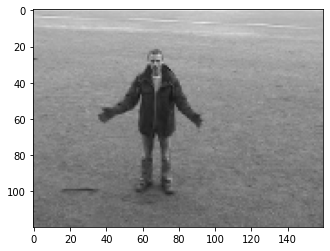

In [7]:
videodata = skvideo.io.vread(dataset[0][0])
videodata = videodata.astype(np.float32) / 255.
print('videodata shape:', videodata.shape)
plt.imshow(videodata[50, ...])

## Визуализация "движения"

motion shape: (504, 120, 160, 1)


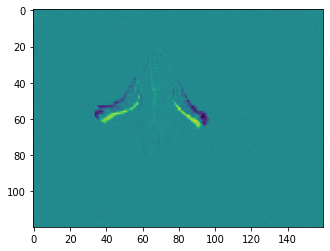

In [8]:
motion = np.mean(videodata[1:, ...] - videodata[:-1, ...], axis=3, keepdims=True)
print('motion shape:', motion.shape)
plt.imshow(motion[50, ..., 0])

## Создание модели CNN

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv3D(32, (5, 5, 5), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((2, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (5, 5, 5), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((2, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (3, 3, 3), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((2, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (3, 3, 3), (1, 1, 1), padding='same', activation=None),
    tf.keras.layers.GlobalAveragePooling3D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(6, activation=None),
])

In [10]:
inp = motion[None, ...]
out = model(inp)

print('Input shape:', inp.shape)
print('Output shape:', out.shape)

Input shape: (1, 504, 120, 160, 1)
Output shape: (1, 6)


## Подготовка к обучению

In [0]:
NUM_EPOCHS = 10

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    optimizer=tf.keras.optimizers.Adam())

writer = tf.summary.create_file_writer('logs/exp1')

## Обучение модели

In [16]:
history = model.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10
26/26 [==============================] - 282s 11s/step - loss: 0.6695 - val_loss: 0.7199
Epoch 2/10
26/26 [==============================] - 286s 11s/step - loss: 0.4220 - val_loss: 0.8466
Epoch 3/10
26/26 [==============================] - 288s 11s/step - loss: 0.4488 - val_loss: 0.5348
Epoch 4/10
26/26 [==============================] - 292s 11s/step - loss: 0.2484 - val_loss: 0.4706
Epoch 5/10
26/26 [==============================] - 296s 11s/step - loss: 0.2548 - val_loss: 0.4810
Epoch 6/10
26/26 [==============================] - 304s 12s/step - loss: 0.2411 - val_loss: 0.4604
Epoch 7/10
26/26 [==============================] - 306s 12s/step - loss: 0.2660 - val_loss: 0.3823
Epoch 8/10
26/26 [==============================] - 307s 12s/step - loss: 0.1634 - val_loss: 0.5924
Epoch 9/10
26/26 [==============================] - 307s 12s/step - loss: 0.1515 - val_loss: 0.3768
Epoch 10/10
26/26 [==============================] - 301s 12s/step - loss: 0.0942 - val_loss: 0.4624

Видно, что на валидационной выборке лосс пеерстал уменьшаться после 7 эпохи. После этого заметно переобучение модели

## Тестирование обученной модели

In [0]:
all_items = []
for cls in classes:
  for fpath in glob.glob(os.path.join(WORKING_DIR, cls, '*.avi')):
    all_items.append([fpath, cls])

True class: handwaving
Predicted class: handwaving


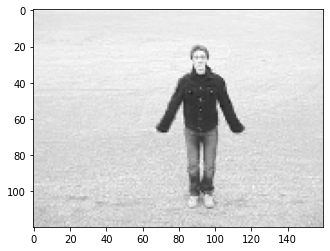

In [21]:
fpath, cls_true = random.choice(all_items)

videodata = skvideo.io.vread(fpath)
videodata = videodata.astype(np.float32) / 255.
plt.imshow(videodata[30, ...])

motion = np.mean(videodata[1:, ...] - videodata[:-1, ...], axis=3, keepdims=True)

out = model(motion[None, ...])[0]
cls_pred = np.argmax(out.numpy())

print('True class:', cls_true)
print('Predicted class:', classes[cls_pred])